# Web attack detection using CICIDS2017 dataset

Training data: "Intrusion Detection Evaluation Dataset" (CICIDS2017). Description page: https://www.unb.ca/cic/datasets/ids-2017.html

The data set is public. Download link: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/

CICIDS2017 combines 8 files recorded on different days of observation (PCAP + CSV). Used archive: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/GeneratedLabelledFlows.zip

In the downloaded archive GeneratedLabelledFlows.zip the file "Thursday" Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv is selected.

Sources:

* [Sharafaldin2018] Iman Sharafaldin, Arash Habibi Lashkari and Ali A. Ghorbani. Toward Generating a New Intrusion Detection Dataset and Intrusion Traffic Characterization. 2018
* [Kostas2018] Kahraman Kostas. Anomaly Detection in Networks Using Machine Learning. 2018 (error was found in assessing the importance of features)
* https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning (error was found in assessing the importance of features)

## Data preprocessing

Source: https://github.com/bozbil/Anomaly-Detection-in-Networks-Using-Machine-Learning/blob/master/01_preprocessing.ipynb [Kostas2018].

In [2]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

Download the dataset from Github to Google Colab and unzip it.

In [3]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

--2025-06-20 20:39:10--  https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip [following]
--2025-06-20 20:39:10--  https://github.com/fisher85/ml-cybersecurity/raw/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fisher85/ml-cybersecurity/refs/heads/master/python-web-attack-detection/datasets/Thursday-WorkingHours-Morning-WebAttacks.pcap_IS

We use "engine=python" to avoid the "UnicodeDecodeError: 'utf-8' codec can't decode byte 0x96 in position 11: invalid start byte" encoding error.

In [5]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', engine='python', encoding='latin-1')

Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv file contains 458968 records, 85 columns.

In [6]:
df.shape

(458968, 85)

The columns "Fwd Header Length" and "Fwd Header Length.1" are identical, the second one is removed, 84 columns remain.

In [7]:
df.columns = df.columns.str.strip()
df = df.drop(columns=['Fwd Header Length.1'])
df.shape

(458968, 84)

When assessing the distribution of labels, it turns out that out of 458968 records there are many blank records ("BENIGN" - benign background traffic).

In [8]:
df['Label'].unique()

array(['BENIGN', 'Web Attack \x96 Brute Force', 'Web Attack \x96 XSS',
       'Web Attack \x96 Sql Injection', nan], dtype=object)

In [9]:
df['Label'].value_counts()

,count
Label,
BENIGN,168186
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


Delete blank records.

In [10]:
df = df.drop(df[pd.isnull(df['Flow ID'])].index)
df.shape

(170366, 84)

The "Flow Bytes/s" and "Flow Packets/s" columns have non-numerical values, replace them.

In [11]:
df.replace('Infinity', -1, inplace=True)
df[["Flow Bytes/s", "Flow Packets/s"]] = df[["Flow Bytes/s", "Flow Packets/s"]].apply(pd.to_numeric)

Replace the NaN values and infinity values with -1.

In [12]:
df.replace([np.inf, -np.inf, np.nan], -1, inplace=True)

Convert string characters to numbers, use LabelEncoder, not OneHotEncoder.

In [13]:
string_features = list(df.select_dtypes(include=['object']).columns)
string_features.remove('Label')
string_features

['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']

In [14]:
le = preprocessing.LabelEncoder()
df[string_features] = df[string_features].apply(lambda col: le.fit_transform(col))

### Undersampling against unbalance

Dataset is unbalanced: total records = 170366, "BENIGN" records = 168186, records with attacks much less: 1507 + 652 + 21 = 2180.

In [15]:
benign_total = len(df[df['Label'] == "BENIGN"])
benign_total

168186

In [16]:
attack_total = len(df[df['Label'] != "BENIGN"])
attack_total

2180

In [17]:
df.to_csv("web_attacks_unbalanced.csv", index=False)
df['Label'].value_counts()

,count
Label,
BENIGN,168186
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


We use **undersampling** to correct class imbalances: we remove most of the "BENIGN" records.

Form a balanced dataset web_attacks_balanced.csv in proportion: 30% attack (2180 records), 70% benign data (2180 / 30 * 70 ~ = 5087 records).

Algorithm to form a balanced df_balanced dataset:

* All the records with the attacks are copied to the new dataset.
* There are two conditions for copying "BENIGN" records to the new dataset:

     1. The next record is copyied with the benign_inc_probability.
     2. The total number of "BENIGN" records must not exceed the limit of 5087 records.

Сalculate the probability of copying a "BENIGN" record. The enlargement multiplier is used to get exactly 70% benign data (5087 records).

In [18]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

5086.666666666667 0.03326872232726466


Copy records from df to df_balanced, save dataset **web_attacks_balanced.csv**.

In [19]:
import random
indexes = []
benign_included_count = 0
for index, row in df.iterrows():
    if (row['Label'] != "BENIGN"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df.loc[indexes]

In [20]:
df_balanced['Label'].value_counts()

,count
Label,
BENIGN,5087
Web Attack  Brute Force,1507
Web Attack  XSS,652
Web Attack  Sql Injection,21


If necessary, we can keep a single class of attack for experiments.

In [21]:
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Brute Force"]
# df_balanced = df_balanced[df_balanced['Label'] != "Web Attack – Sql Injection"]
# df_balanced['Label'].value_counts()

In [22]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

In [23]:
df = pd.read_csv('web_attacks_balanced.csv')

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [24]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [25]:
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded, errors='ignore')

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset.

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

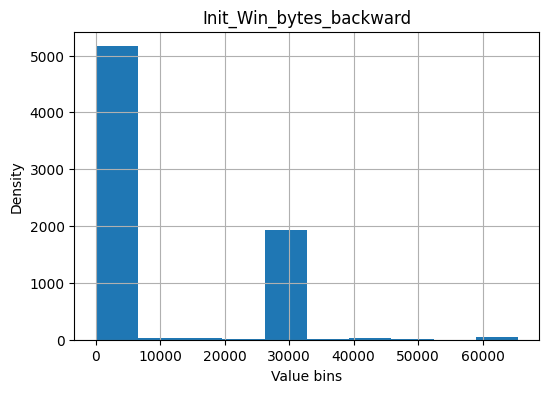

In [26]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

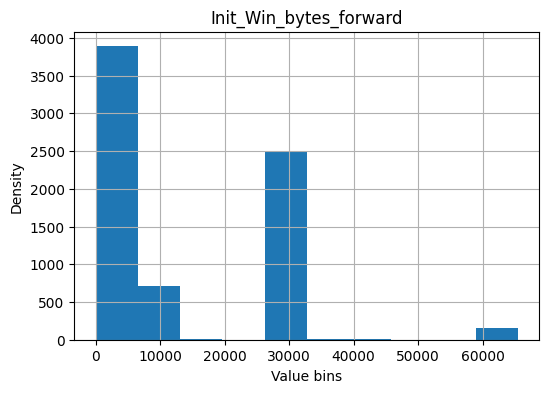

In [27]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [28]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2, errors='ignore')

In [29]:
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(3544), np.int64(1): np.int64(1542)}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)

In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.

By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.96267191, 0.94891945, 0.98035363, 0.94891945, 0.95088409,
       0.97053045, 0.96850394, 0.96062992, 0.95275591, 0.9488189 ])

In [32]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.50
|   |--- Fwd IAT Std <= 2489420.88
|   |   |--- class: 0
|   |--- Fwd IAT Std >  2489420.88
|   |   |--- Fwd IAT Min <= 11156.50
|   |   |   |--- class: 1
|   |   |--- Fwd IAT Min >  11156.50
|   |   |   |--- class: 0
|--- Packet Length Mean >  0.50
|   |--- Subflow Fwd Bytes <= 37140.00
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  37140.00
|   |   |--- class: 1



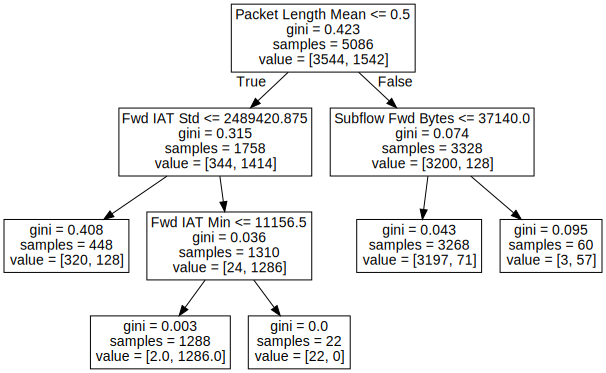

In [33]:
from graphviz import Source
from sklearn import tree
Source(tree.export_graphviz(decision_tree, out_file=None, feature_names=X.columns))

Analyze the confusion matrix. Which classes are confidently classified by the model?

In [34]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{np.int64(0): np.int64(1543), np.int64(1): np.int64(638)}

In [35]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1543,    0],
       [  81,  557]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [36]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.17793375, 0.        , 0.02372851, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.74247073,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05586702, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [37]:
sfm.threshold_

np.float64(0.013513513513513514)

In [38]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [39]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7424707264065943
1.	Fwd IAT Std - 0.17793374952882063
2.	Subflow Fwd Bytes - 0.055867016552581
3.	Fwd IAT Min - 0.023728507512004133
4.	Active Min - 0.0
5.	Active Max - 0.0
6.	Idle Std - 0.0
7.	Idle Mean - 0.0
8.	Idle Min - 0.0
9.	Idle Max - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [43]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [44]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
webattack_features = []

for index, i in enumerate(indices[:20]):
    webattack_features.append(features[i])
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#51	0.084	Average Packet Size
2.	#13	0.079	Flow Bytes/s
3.	#38	0.062	Max Packet Length
4.	#39	0.061	Packet Length Mean
5.	#7	0.059	Fwd Packet Length Mean
6.	#52	0.054	Avg Fwd Segment Size
7.	#23	0.053	Fwd IAT Min
8.	#61	0.051	Subflow Fwd Bytes
9.	#3	0.038	Total Length of Fwd Packets
10.	#15	0.033	Flow IAT Mean
11.	#21	0.032	Fwd IAT Std
12.	#5	0.031	Fwd Packet Length Max
13.	#14	0.025	Flow Packets/s
14.	#33	0.025	Fwd Header Length
15.	#0	0.023	Flow Duration
16.	#35	0.022	Fwd Packets/s
17.	#16	0.021	Flow IAT Std
18.	#20	0.018	Fwd IAT Mean
19.	#18	0.018	Flow IAT Min
20.	#22	0.016	Fwd IAT Max


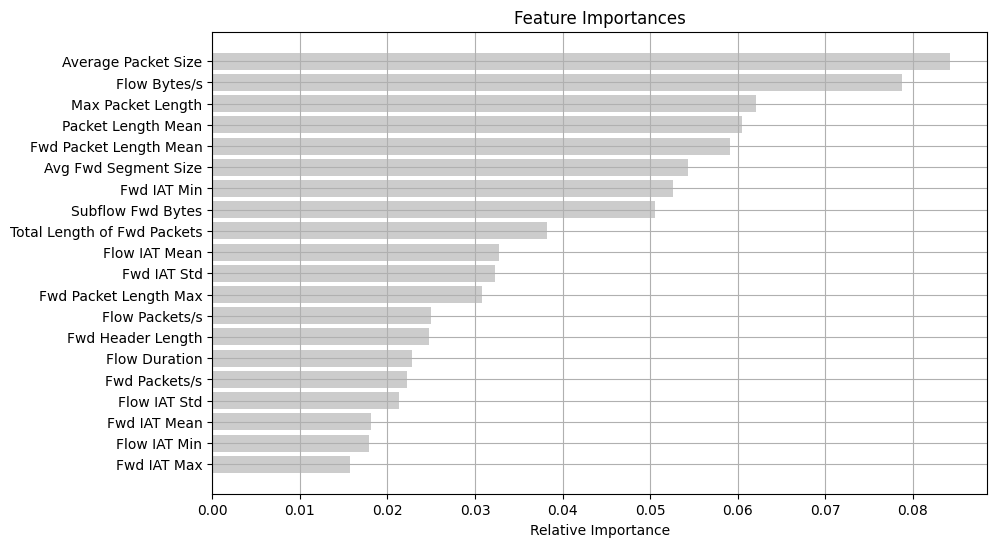

In [45]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (10, 6)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#cccccc', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300, bbox_inches='tight')
plt.show()

In [46]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1524,   19],
       [  23,  615]])

Next, for experiments, we keep the first max_features of features with maximum importance.

In [47]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Packet Length Mean',
 'Fwd Packet Length Mean',
 'Avg Fwd Segment Size',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Packet Length Max',
 'Flow Packets/s',
 'Fwd Header Length',
 'Flow Duration',
 'Fwd Packets/s',
 'Flow IAT Std',
 'Fwd IAT Mean',
 'Flow IAT Min',
 'Fwd IAT Max']

## Analysis of selected features

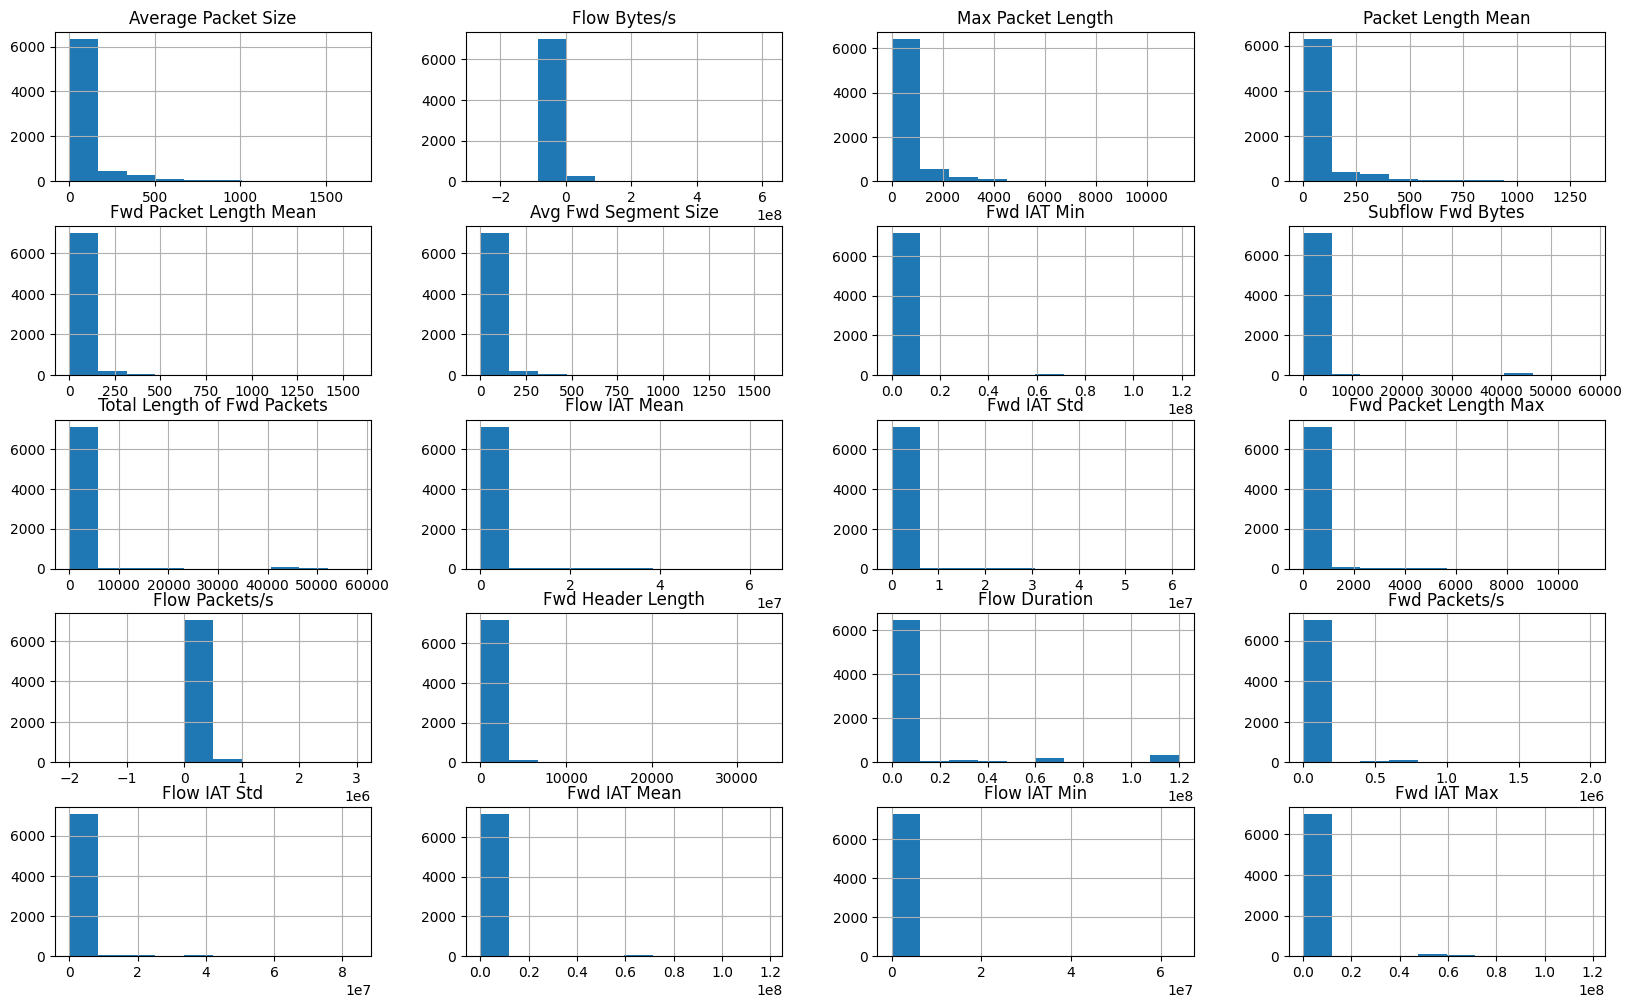

In [48]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

In [49]:
!pip install facets-overview

Create the feature stats for the datasets and stringify it.

In [50]:
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator

gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train + test', 'table': df[webattack_features]}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

/usr/local/lib/python3.11/dist-packages/facets_overview/base_generic_feature_statistics_generator.py:121: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  flattened = x.ravel()


Display the facets overview visualization for this data.

In [51]:
from IPython.core.display import display, HTML

HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

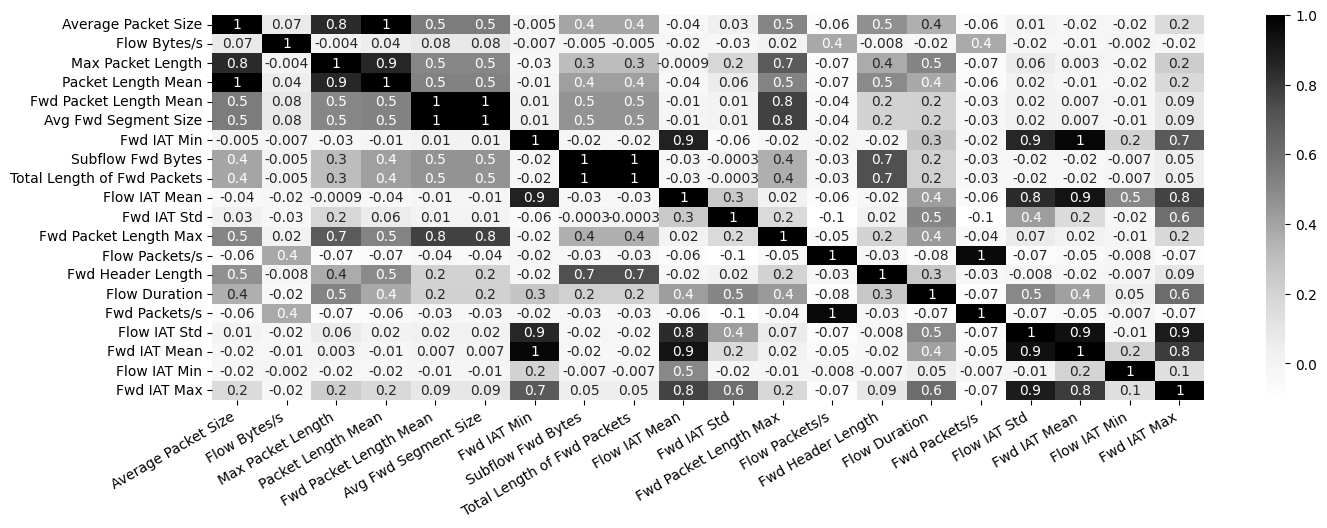

In [52]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap.png', dpi=300, bbox_inches='tight')

Remove correlated features.

In [53]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes',
                 'Fwd Packets/s', 'Fwd IAT Total', 'Fwd IAT Max'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Average Packet Size',
 'Flow Bytes/s',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Packet Length Max',
 'Flow Packets/s']

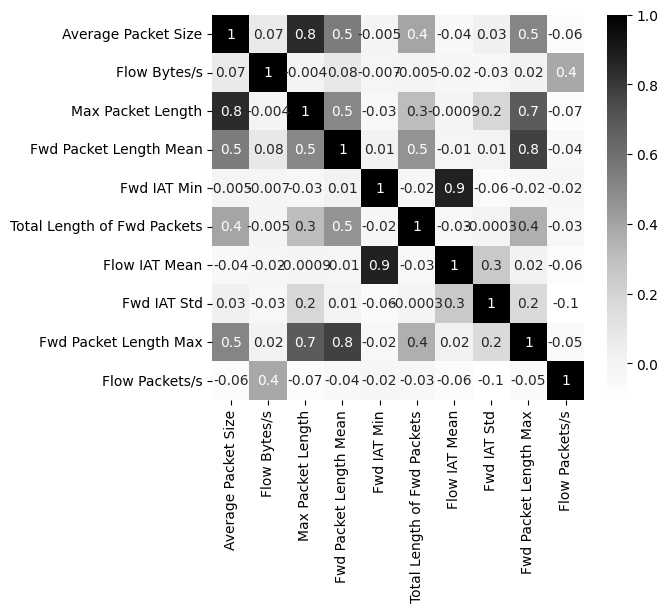

In [54]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys');

## Hyperparameter selection

Reopen the dataset.

In [61]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


We get the list of RandomForestClassifier parameters.

In [62]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [63]:

parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3],
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 20, 30, 50]}
# Change the scoring parameter from a set to a list
scoring = ['f1', 'accuracy']

gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)

try:
    get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
    # Explicitly check if the attribute exists after fitting
    if hasattr(gcv, 'cv_results_'):
        results = gcv.cv_results_
        print("cv_results_ attribute found successfully.")
        # You can then proceed with your analysis of the results
    else:
        print("Error: 'gcv' object does not have 'cv_results_' attribute after fit.")
        # Add more debugging here, like checking the type of gcv or any error messages from fit if possible
        print(f"Type of gcv: {type(gcv)}")
        # If running in a standard Python script, you might not have the %time magic,
        # in which case you would just call gcv.fit(X, y) and handle exceptions.
except Exception as e:
    print(f"An error occurred during gcv.fit: {e}")
    # This would catch errors during the fit process itself

CPU times: user 12.7 s, sys: 33.5 ms, total: 12.7 s
Wall time: 12.9 s
cv_results_ attribute found successfully.


In [64]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_f1,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.051941,0.017167,0.008568,0.002813,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.885246,...,0.906575,0.905657,0.909021,0.908257,0.904893,0.905366,0.905672,0.908424,0.906564,0.001702
1,0.048292,0.012458,0.005444,0.001732,2,3,3,10,"{'max_depth': 2, 'max_features': 3, 'min_sampl...",0.859375,...,0.943884,0.943272,0.944343,0.943884,0.944801,0.939612,0.939459,0.944657,0.943290,0.001945
2,0.045373,0.002177,0.004532,0.000775,3,3,3,10,"{'max_depth': 3, 'max_features': 3, 'min_sampl...",0.887755,...,0.957034,0.956575,0.957951,0.957492,0.957492,0.953983,0.953677,0.958110,0.956776,0.001563
3,0.054220,0.004162,0.004944,0.000786,4,3,3,10,"{'max_depth': 4, 'max_features': 3, 'min_sampl...",0.915423,...,0.971407,0.970642,0.970489,0.962691,0.966514,0.962850,0.966213,0.972481,0.968625,0.003568
4,0.056027,0.002410,0.004610,0.000310,5,3,3,10,"{'max_depth': 5, 'max_features': 3, 'min_sampl...",0.913151,...,0.971407,0.974006,0.973089,0.971407,0.974006,0.975845,0.975386,0.979667,0.974542,0.002297


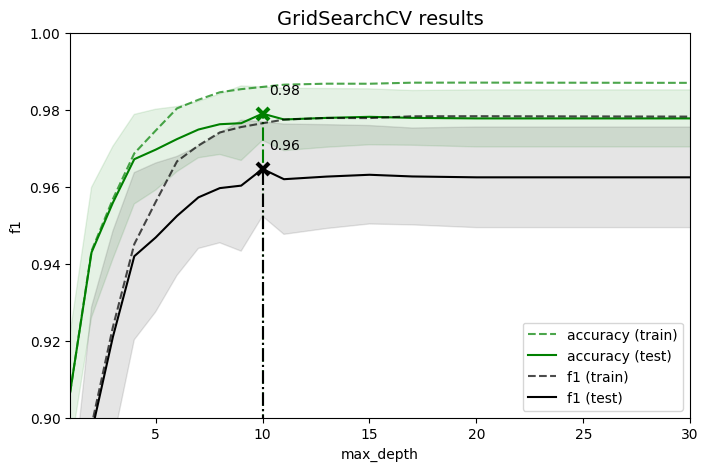

In [65]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 5))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(1, 30)
ax.set_ylim(0.9, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

### Grid search

In [66]:
parameters = {'n_estimators': [30, 50, 70],
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10],
              'max_depth': [10, 17, 23]}

# parameters = {'n_estimators': [250]}

The operation may take a long time, 3-5 minutes depending on the computer performance.

In [67]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=3, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: user 2min 16s, sys: 234 ms, total: 2min 16s
Wall time: 2min 17s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_depth': [10, 17, 23],
                         'max_features': [3, 5, 7, 10],
                         'min_samples_leaf': [3, 5, 7],
                         'n_estimators': [30, 50, 70]},
             refit='f1', return_train_score=True, scoring=['f1', 'accuracy'])

Let's take a look at the results of the parameter selection.

In [68]:
gcv.best_estimator_

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=5,
                       n_estimators=50, random_state=1)

In [69]:
gcv.best_params_

{'max_depth': 17,
 'max_features': 10,
 'min_samples_leaf': 5,
 'n_estimators': 50}

In [70]:
gcv.best_score_

np.float64(0.9598154457318167)

## Final model

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5086, 10) (5086,)
(2181, 10) (2181,)


In [72]:
rfc = RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3, n_estimators=50, random_state=42, oob_score=True)
# rfc = RandomForestClassifier(n_estimators=250, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

In [73]:
features = X.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)[::-1]

for index, i in enumerate(indices[:10]):
    print('{}.\t#{}\t{:.3f}\t{}'.format(index + 1, i, importances[i], features[i]))

1.	#2	0.394	Max Packet Length
2.	#0	0.262	Average Packet Size
3.	#7	0.156	Fwd IAT Std
4.	#4	0.057	Fwd IAT Min
5.	#5	0.057	Total Length of Fwd Packets
6.	#9	0.028	Flow Packets/s
7.	#6	0.027	Flow IAT Mean
8.	#3	0.014	Fwd Packet Length Mean
9.	#8	0.002	Fwd Packet Length Max
10.	#1	0.002	Flow Bytes/s


In [74]:
y_pred = rfc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1528,   15],
       [  23,  615]])

In [75]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9825767996331958
Precision = 0.9761904761904762
Recall = 0.9639498432601881
F1 = 0.9700315457413249


## Model saving

In [76]:
import pickle
with open('webattack_detection_rf_model.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## Model approbation

Open the previously saved model.

In [77]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)

Reopen the dataset.

In [78]:
df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(7267, 10) (7267,)


If necessary, we will work with our own dataset.

In [79]:
#df = pd.read_csv('mix_labelled.csv')
#y_test = df['Label'].values
#X_test = df[webattack_features]
#print(X_test.shape, y_test.shape)

In [80]:
X_test.head()

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Flow Packets/s
0,98.0,5.824269e+03,106.0,45.0,0.0,45.0,25926.000000,0.0,45.0,77.142637
1,58.5,7.835455e+03,66.0,34.0,4.0,68.0,8508.333333,0.0,34.0,156.709109
2,63.5,1.361963e+06,79.0,32.0,1.0,64.0,54.333333,0.0,32.0,24539.877300
3,3.0,1.935484e+05,6.0,0.0,0.0,0.0,20.666667,0.0,0.0,64516.129030
4,48.0,7.619048e+05,48.0,32.0,49.0,64.0,70.000000,0.0,32.0,19047.619050


In [81]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.021008968353271484 seconds
Benign records detected (0), attacks detected (1):


{np.int64(0): np.int64(5103), np.int64(1): np.int64(2164)}

Confusion matrix:

      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

In [82]:
confusion_matrix(y_test, y_pred)

array([[5045,   42],
       [  58, 2122]])

In [83]:
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.9862391633411312
Precision = 0.9805914972273567
Recall = 0.9733944954128441
F1 = 0.9769797421731123


Manual calculation of the confusion matrix:
    
    array([[5075,   12],
           [   1, 2179]], dtype=int64)
  
      0  1 - predicted value (Wikipedia uses different convention for axes)
    0 TN FP
    1 FN TP

    Точность
    Precision = TP / (TP + FP) = 2179 / (2179 + 12) = 0.9945230488361478

    Полнота
    Recall = TP / (TP + FN) = 2179 / (2179 + 1) = 0.9995412844036697

    F-мера, параметр = 1, гармоническое среднее точности и полноты, множитель = 2
    F1 = 2 * (precision * recall) / (precision + recall) = 0.9970258522077328

    Доля правильных ответов
    Accuracy = TP + TN / (TP + TN + FP + FN) = (2179 + 5075) / 7267 = 0.998211091234347

In [84]:
predict = pd.DataFrame({'Predict': rfc.predict(X_test)})
label = pd.DataFrame({'Label': y_test})
result = X_test.join(label).join(predict)

In [85]:
result[result['Predict'] == 1]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Flow Packets/s,Label,Predict
321,0.000000,0.000000,0.0,0.000000,0.0,0.0,51.0000,0.000000e+00,0.0,39215.686270,0,1
406,238.785714,644.729782,1047.0,146.000000,4.0,1022.0,398855.2308,5.614102e+04,372.0,2.700035,1,1
410,0.000000,0.000000,0.0,0.000000,0.0,0.0,81.0000,0.000000e+00,0.0,24691.358020,1,1
411,199.916667,455.121233,1066.0,138.428571,323.0,969.0,479193.0000,2.003103e+06,561.0,2.276555,1,1
419,218.454545,478.624430,1066.0,139.000000,18.0,973.0,502063.8000,2.021330e+06,565.0,2.190957,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6662,0.000000,0.000000,0.0,0.000000,0.0,0.0,84.0000,0.000000e+00,0.0,23809.523810,0,1
6734,0.000000,0.000000,0.0,0.000000,0.0,0.0,79.0000,0.000000e+00,0.0,25316.455700,0,1
6963,0.000000,0.000000,0.0,0.000000,0.0,0.0,72.0000,0.000000e+00,0.0,27777.777780,0,1
7012,0.000000,0.000000,0.0,0.000000,0.0,0.0,71.0000,0.000000e+00,0.0,28169.014080,0,1


In [86]:
result[410:430]

,Average Packet Size,Flow Bytes/s,Max Packet Length,Fwd Packet Length Mean,Fwd IAT Min,Total Length of Fwd Packets,Flow IAT Mean,Fwd IAT Std,Fwd Packet Length Max,Flow Packets/s,Label,Predict
410,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,8.100000e+01,0.000000e+00,0.0,2.469136e+04,1,1
411,199.916667,4.551212e+02,1066.0,138.428571,323.0,969.0,4.791930e+05,2.003103e+06,561.0,2.276555e+00,1,1
412,22.666667,5.692308e+05,31.0,15.500000,1.0,31.0,3.250000e+01,0.000000e+00,31.0,4.615385e+04,0,0
413,0.000000,0.000000e+00,0.0,0.000000,0.0,0.0,2.900000e+01,0.000000e+00,0.0,6.896552e+04,0,0
414,9.000000,1.333333e+05,6.0,6.000000,0.0,6.0,9.000000e+01,0.000000e+00,6.0,2.222222e+04,0,0
415,31.000000,1.550000e+07,31.0,15.500000,2.0,31.0,2.000000e+00,0.000000e+00,31.0,1.000000e+06,0,0
416,73.000000,6.532663e+05,98.0,32.000000,1.0,64.0,1.326667e+02,0.000000e+00,32.0,1.005025e+04,0,0
417,421.000000,1.172616e+04,1460.0,101.000000,72.0,1212.0,3.769775e+04,1.255312e+05,725.0,2.785312e+01,0,0
418,134.025641,4.541003e+01,1460.0,44.200000,1.0,884.0,3.029124e+06,4.886716e+06,419.0,3.388160e-01,0,0
419,218.454545,4.786244e+02,1066.0,139.000000,18.0,973.0,5.020638e+05,2.021330e+06,565.0,2.190957e+00,1,1
